In [1]:
# for table imports
import glob
import numpy as np
import pandas as pd
import warnings
import time
import pickle

from biom import Table, load_table
from biom.util import biom_open
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.composition import closure, clr
from tqdm.notebook import tqdm

# RPCA & beta-divs
import qiime2 as q2
from qiime2.plugins.diversity.actions import beta, pcoa
from gemelli.rpca import rpca, joint_rpca, rpca_table_processing

# for CV splits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
'''
#code below only used for PBP response and feature overlap analysis
#need to run this script once without this cell (for orig. results in fig2) 
#and once with it (for feature overlap analysis - MOFA+ and Joint-RPCA only)
#re-run MOFA+ and Joint-RPCA with proteomics data included and updated labels
#import proteomics and relabel features
prot_table = load_table('../../data/simulations/ihmp/HMP2_proteomics_ecs.biom')

update_prot_ids = {id: "Prot " + id for id in prot_table.ids(axis='observation')}
prot_table = prot_table.update_ids(update_prot_ids, axis='observation')

with biom_open('../../data/simulations/ihmp/HMP2_proteomics_ecs.biom', 'w') as f:
    prot_table.to_hdf5(f, "updated-ids")'''

### import data

In [2]:
tables = {omics_.split('/')[-1].split('.')[0]:rpca_table_processing(load_table(omics_),
                                                                    min_sample_count=0,
                                                                    min_feature_count=0,
                                                                    min_feature_frequency=0)
          for omics_ in glob.glob('../../data/simulations/ihmp/*.biom')
          if not any ('_' + str(d_) in omics_ for d_ in [range(1,20)])}
tables['meta_g_taxonomic_profiles'] = load_table('../../data/simulations/ihmp/meta_g_taxonomic_profiles.biom')
tables.pop('shared_meta_g_taxonomic_profiles')

metadata = pd.read_csv('../../data/simulations/ihmp/sample-metadata.txt', sep='\t', index_col=0)
shared_samps = set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata.index)
metadata = metadata.reindex(shared_samps)
metadata = metadata.sort_values('week_num')
metadata['External ID'] = metadata.index
metadata = metadata.groupby('Participant ID').last()
metadata.index = metadata['External ID']
metadata['diagnosis'] = [x.replace('UC','IBD').replace('CD','IBD') for x in metadata.diagnosis]

# re-close metaG/T data
shared_samps = set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata.index)
tables = {t_k:t_.filter(shared_samps) for t_k, t_ in tables.items()}
for t_ in ['meta_g_taxonomic_profiles','meta_t_ecs']:
    tbl_tmp = tables[t_].to_dataframe().copy().apply(closure)
    tables[t_] = Table(tbl_tmp.values, tbl_tmp.index, tbl_tmp.columns)
metadata.diagnosis.value_counts()

IBD       49
nonIBD    19
Name: diagnosis, dtype: int64

In [3]:
tables

{'virome_virmap_analysis': 260 x 68 <class 'biom.table.Table'> with 269 nonzero entries (1% dense),
 'meta_t_ecs': 69170 x 68 <class 'biom.table.Table'> with 355263 nonzero entries (7% dense),
 'meta_g_taxonomic_profiles': 1479 x 68 <class 'biom.table.Table'> with 12643 nonzero entries (12% dense),
 'HMP2_proteomics_ecs': 830 x 68 <class 'biom.table.Table'> with 8378 nonzero entries (14% dense),
 'HMP2_metabolomics': 81867 x 68 <class 'biom.table.Table'> with 3442863 nonzero entries (61% dense)}

In [ ]:
#Note: This only needs to be run once and saved.
'''
#save dict to map features and modality
# mod_features = {}
# for mod_ in tables.keys():
#     feat_ids_ = tables[mod_].ids(axis='observation')
#     mod_features[mod_] = feat_ids_
# save modality mapping - only need to run once
#with open("../../data/simulations/ihmp/mod_to_feature_map.pkl", "wb") as f:
#    pickle.dump(mod_features, f)

#create the "reverse" feature map, where each feature is mapped to a modality
# mod_features_rev = {}
# omic_title = {'virome_virmap_analysis': 'Virome', 'meta_t_ecs': 'MetaT', 'All': 'All',
#               'meta_g_taxonomic_profiles': 'MetaG', 'HMP2_metabolomics': 'Metabolomics',
#               'HMP2_proteomics_ecs': 'Proteomics'}

# for mod_ in tables.keys():
#     feat_ids_ = tables[mod_].ids(axis='observation')
#     for feats_ in feat_ids_:
#         mod_features_rev[feats_] = omic_title[mod_]

# save modality mapping - only need to run once
# with open("../../data/simulations/ihmp/mod_to_feature_map_reverse.pkl", "wb") as f:
#    pickle.dump(mod_features_rev, f)
'''

In [11]:
#Note: This only needs to be run once and saved.
'''
# for d_, depth in zip([11, 9, 7, 5, 3],
#                      [64000, 16000, 4000, 1000, 250]):
#     rel_microbe_subsampled = tables['meta_g_taxonomic_profiles'].to_dataframe().copy()
#     for s in rel_microbe_subsampled.columns:
#         dist_ = np.random.multinomial(depth, rel_microbe_subsampled[s].values)
#         rel_microbe_subsampled[s] = dist_
#     rel_microbe_subsampled.index.name ='OTU_ID'
#     rel_microbe_subsampled = rel_microbe_subsampled.apply(closure)
#     rel_microbe_subsampled = Table(rel_microbe_subsampled.values,
#                                    rel_microbe_subsampled.index,
#                                    rel_microbe_subsampled.columns)  
#     with biom_open('../../data/simulations/ihmp/meta_g_taxonomic_profiles_%i_last.biom' % (d_), 'w') as f:
#       rel_microbe_subsampled.to_hdf5(f, str(d_))
#     # save
#     tables['meta_g_taxonomic_profiles_%i' % (d_)] = rel_microbe_subsampled
'''

In [12]:
# add subsampled table
for d_ in [11, 9, 7, 5, 3]:
    tables['meta_g_taxonomic_profiles_%i' % (d_)] = load_table('../../data/simulations/ihmp/meta_g_taxonomic_profiles_%i_last.biom' % (d_))
tables

{'virome_virmap_analysis': 260 x 68 <class 'biom.table.Table'> with 269 nonzero entries (1% dense),
 'meta_t_ecs': 69170 x 68 <class 'biom.table.Table'> with 355263 nonzero entries (7% dense),
 'meta_g_taxonomic_profiles': 1479 x 68 <class 'biom.table.Table'> with 12643 nonzero entries (12% dense),
 'HMP2_proteomics_ecs': 830 x 68 <class 'biom.table.Table'> with 8378 nonzero entries (14% dense),
 'HMP2_metabolomics': 81867 x 68 <class 'biom.table.Table'> with 3442863 nonzero entries (61% dense),
 'meta_g_taxonomic_profiles_11': 1479 x 68 <class 'biom.table.Table'> with 11068 nonzero entries (11% dense),
 'meta_g_taxonomic_profiles_9': 1479 x 68 <class 'biom.table.Table'> with 9398 nonzero entries (9% dense),
 'meta_g_taxonomic_profiles_7': 1479 x 68 <class 'biom.table.Table'> with 7358 nonzero entries (7% dense),
 'meta_g_taxonomic_profiles_5': 1479 x 68 <class 'biom.table.Table'> with 5087 nonzero entries (5% dense),
 'meta_g_taxonomic_profiles_3': 1479 x 68 <class 'biom.table.Table'>

### make train test splits

In [13]:
#Note: This only needs to be run once and saved.
'''
# for f in range(10):
#     f += 1
#     train_, test_ = train_test_split(metadata, shuffle=True,
#                                      stratify=metadata['diagnosis'],
#                                      test_size=0.25)
#     metadata['train_test_%i' % (f)] = 'train'
#     metadata.loc[test_.index, 'train_test_%i' % (f)] = 'test'
# metadata.to_csv('../../data/simulations/ihmp/sample-metadata-plus-train-tests-last.csv')
'''

In [14]:
metadata = pd.read_csv('../../data/simulations/ihmp/sample-metadata-plus-train-tests-last.csv', index_col=0)
metadata.columns

Index(['site_sub_coll', 'data_type', 'week_num', 'date_of_receipt',
       'interval_days', 'visit_num', 'Research Project', 'PDO Number',
       'GSSR IDs', 'Product',
       ...
       'train_test_1', 'train_test_2', 'train_test_3', 'train_test_4',
       'train_test_5', 'train_test_6', 'train_test_7', 'train_test_8',
       'train_test_9', 'train_test_10'],
      dtype='object', length=499)

### MOFA

In [15]:
tables_joint_ = [['virome_virmap_analysis','meta_t_ecs',
                  'meta_g_taxonomic_profiles','HMP2_metabolomics']]
tables_joint_ += [['virome_virmap_analysis','meta_t_ecs',
                  'meta_g_taxonomic_profiles_%i' % (d_),
                   'HMP2_metabolomics']
                  for d_ in [11, 9, 7, 5, 3]]

transformation_ = {'virome_virmap_analysis':clr,
                     'meta_t_ecs':clr,
                     'meta_g_taxonomic_profiles':clr,
                     'HMP2_metabolomics':clr}
for d_ in [11, 9, 7, 5, 3]:
    transformation_['meta_g_taxonomic_profiles_%i' % (d_)] = clr

for tables_ in tables_joint_:
    for f_ in range(10):
        f_ += 1
        tt_col = 'train_test_%i' % (f_)
        train_ = metadata[metadata[tt_col] == 'train'].index
        test_ = metadata[metadata[tt_col] == 'test'].index
        for use_sub_, lbl_out_ in zip([train_, test_], ['train','test']):
            stacked_clr_tables = {t_:pd.DataFrame(tables[t_].matrix_data.toarray() + 1,
                                                  tables[t_].ids('observation'),
                                                  tables[t_].ids()).loc[:, use_sub_].apply(transformation_[t_]).stack().reset_index()
                                  for t_ in tables_}
            
            #version1 - original results (figure 2)
            stacked_clr_tables = pd.concat(stacked_clr_tables)
            stacked_clr_tables.columns = ["feature","sample","value"]
            stacked_clr_tables = stacked_clr_tables.reset_index().drop(['level_1'], axis=1).rename({'level_0':'view'}, axis=1)
            stacked_clr_tables = stacked_clr_tables[["sample","feature","value","view"]]
            stacked_clr_tables['feature'] = stacked_clr_tables['view'] + '_' + stacked_clr_tables['feature']
            
            # need to encode the feature names because MOFA does not like them
            feat_map = {v:i for i, v in enumerate(set(stacked_clr_tables.feature))}
            stacked_clr_tables['feature'] = [feat_map[v] for v in stacked_clr_tables['feature']]
            #tables below not provided in code ocean due to memory constraints
            #stacked_clr_tables.to_csv('../../data/simulations/ihmp/mofa-reformatted/fold-%i-subset-%s-%s-test.tsv.gz' % (f_, lbl_out_, tables_[2]), sep='\t', compression='gzip')

            '''
            #version2 - results used for feature overlap analysis and include proteomics data
            stacked_clr_tables = pd.concat(stacked_clr_tables)
            stacked_clr_tables.columns = ["orig_feature","sample","value"]
            stacked_clr_tables = stacked_clr_tables.reset_index().drop(['level_1'], axis=1).rename({'level_0':'view'}, axis=1)
            stacked_clr_tables = stacked_clr_tables[["sample","orig_feature","value","view"]]
            stacked_clr_tables['view_feature'] = stacked_clr_tables['view'] + '_' + stacked_clr_tables['orig_feature']
            
            # need to encode the feature names because MOFA does not like them
            feat_map = {v:i for i, v in enumerate(set(stacked_clr_tables.view_feature))}
            stacked_clr_tables['feature'] = [feat_map[v] for v in stacked_clr_tables['view_feature']]

            stacked_clr_tables_save = stacked_clr_tables[["sample","feature","value","view"]].copy()
            stacked_clr_tables_map = stacked_clr_tables[["sample","feature","orig_feature","view"]].copy()

            #tables below not provided in code ocean due to memory constraints
            stacked_clr_tables_save.to_csv('../../results/simulations/ihmp/stacked-tables-last-sims/fold-%i-subset-%s-%s.tsv.gz' % (f_, lbl_out_, tables_[2]), sep='\t', compression='gzip')
            stacked_clr_tables_map.to_csv('../../results/simulations/ihmp/stacked-tables-last-sims/fold-%i-subset-%s-%s-map.tsv.gz' % (f_, lbl_out_, tables_[2]), sep='\t', compression='gzip')

            #feature maps should be exactly the same across folds, so one will be provided to run the feature overlap script
            '''

#### 3.1-ihmp-mofa.R is used to generate results from the tables saved above

### run beta diversity metrics (no tree)

In [13]:
dist_res_others = {}
ord_res_others = {}
for f in range(10):
    f += 1
    tt_col = 'train_test_%i' % (f)
    for metric in ['braycurtis','aitchison']:

        for (tbl_id, tbl_) in tables.items():

            # produce train/test PCoA results on distances
            tbl_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', tbl_.copy())
            q2dist_tmp = beta(tbl_q2, metric=metric).distance_matrix
            ord_tmp = pcoa(q2dist_tmp).pcoa.view(OrdinationResults)
            ord_ = ord_tmp.samples.copy()[[0,1,2]]
            ord_.columns = ['PC1','PC2','PC3']
            ord_ = pd.concat([ord_,  metadata], axis=1, sort=False)
            dist_res_others[(f, tbl_id, metric)] = q2dist_tmp.view(DistanceMatrix)
            ord_res_others[(f, tbl_id, metric)] = ord_

# save 
"""
# for (f_, omic_, metric_), obj_ in ord_res_others.items():
#     obj_.to_csv('../../results/simulations/ihmp/all-others/%i-%s-%s-ord.csv' % (f_, omic_, metric_))
# for (f_, omic_, metric_), obj_ in dist_res_others.items():
#     obj_.write('../../results/simulations/ihmp/all-others/%i-%s-%s-dist.txt' % (f_, omic_, metric_))
"""   

### check each dataset independently with RPCA

In [14]:
cv_res = {}
dist_res = {}
ord_res = {}
ord_all_res = {}

for f in range(10):
    f += 1
    tt_col = 'train_test_%i' % (f)
    for tbl_id, tbl_ in tables.items():
        ord_, dist_, cv_plt = joint_rpca([tbl_.copy()],
                                         sample_metadata=metadata,
                                         train_test_column=tt_col,
                                         min_feature_frequency=0,
                                         min_sample_count=0,
                                         min_feature_count=0,
                                         max_iterations=5)
        ord_all_res[(f, tbl_id)] = ord_
        cv_res[(f, tbl_id)] = cv_plt
        dist_res[(f, tbl_id)] = dist_
        ord_ = pd.concat([ord_.samples, metadata], axis=1, sort=False)
        ord_res[(f, tbl_id)] = ord_

# save
'''
# for (f_, tbl_id), obj_ in ord_res.items():
#    obj_.to_csv('../../results/simulations/ihmp/rpca/%i-%s-ord.csv' % (f_, tbl_id))
# for (f_, tbl_id), obj_ in dist_res.items():
#    obj_.write('../../results/simulations/ihmp/rpca/%i-%s-dist.txt' % (f_, tbl_id))
'''

In [15]:
# fig, axn = plt.subplots(10, 10, figsize=(50, 25))

# for ax_, (tbl_id, cv_plt) in zip(axn.flatten(), cv_res.items()):
#     ax_.errorbar(cv_plt.index, cv_plt.mean_CV, yerr=cv_plt.std_CV, color='black')
#     ax_.set_title(tbl_id)
# plt.show()


### Joint-RPCA

In [16]:
import warnings
# block all the zero divide warnings
warnings.filterwarnings('ignore')
max_iterations=5

tables_joint_ = [['virome_virmap_analysis','meta_t_ecs',
                  'meta_g_taxonomic_profiles','HMP2_metabolomics']]
tables_joint_ += [['virome_virmap_analysis','meta_t_ecs',
                  'meta_g_taxonomic_profiles_%i' % (d_),
                   'HMP2_metabolomics']
                  for d_ in [11, 9, 7, 5, 3]]
ord_all_res_joint = {}
ord_res_joint = {}
dist_res_joint = {}
cv_res_joint = {}

for f in tqdm(range(10)):
    f += 1
    tt_col = 'train_test_%i' % (f)
    for tables_use in tables_joint_:
        ord_, dist_, cv_plt = joint_rpca([tables[tbl_id].copy() for tbl_id in tables_use],
                                         sample_metadata=metadata,
                                         train_test_column=tt_col,
                                         min_feature_frequency=0,
                                         min_sample_count=0,
                                         min_feature_count=0,
                                         max_iterations=max_iterations)
        ord_all_res_joint[(f, tables_use[2])] = ord_
        cv_res_joint[(f, tables_use[2])] = cv_plt
        dist_res_joint[(f, tables_use[2])] = dist_
        ord_ = pd.concat([ord_.samples, metadata], axis=1, sort=False)
        ord_res_joint[(f, tables_use[2])] = ord_
    
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
# save joint-rpca results
# for (f_, t_), obj_ in ord_all_res_joint.items():
#     obj_.write('../../results/simulations/ihmp/joint-rpca-results/%i-%s-ord-test-%iiter-last.txt' % (f_, t_, max_iterations))
# for (f_, t_), obj_ in dist_res_joint.items():
#     obj_.write('../../results/simulations/ihmp/joint-rpca-results/%i-%s-dist-test-%iiter-last.txt' % (f_, t_, max_iterations))
        

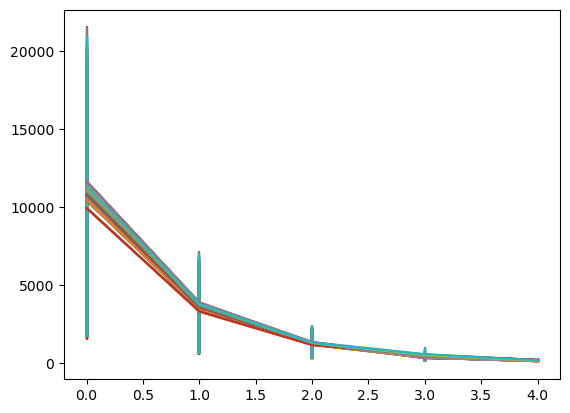

In [19]:
for lbl_, cv_plt in cv_res_joint.items():
    plt.errorbar(cv_plt.index, cv_plt.mean_CV, yerr=cv_plt.std_CV/2, label=lbl_)
plt.show()